In [1]:
import functools
import e3x
from flax import linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

# Disable future warnings.
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1)]

In [2]:
import functools
import jax
import jax.numpy as jnp
from flax import linen as nn
import e3x

class MP_Dipole_Moment(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 118  # Esto es más que suficiente para la mayoría de aplicaciones.

    def dipole_moment(
        self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size
    ):
        # 1. Calcular vectores de desplazamiento.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Forma (num_pairs, 3).

        # 2. Expandir vectores de desplazamiento en funciones base.
        basis = e3x.nn.basis(
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff),
        )

        # 3. Embeder números atómicos en el espacio de características.
        x = e3x.nn.Embed(
            num_embeddings=self.max_atomic_number + 1, features=self.features
        )(atomic_numbers)
        # x tiene forma: (num_atoms, 1, 1, features)

        # 4. Realizar iteraciones (message-passing + refinamiento atomístico).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Iteración final.
                y = e3x.nn.MessagePass(max_degree=2, include_pseudotensors=False)(
                    x, basis, dst_idx=dst_idx, src_idx=src_idx
                )
                x = e3x.nn.change_max_degree_or_type(
                    x, max_degree=2, include_pseudotensors=False
                )
            else:
                y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            y = e3x.nn.add(x, y)

            # Refinamiento atomístico MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)

            # Conexión residual.
            x = e3x.nn.add(x, y)

        # 5. Predecir contribuciones atómicas al momento dipolar con una capa densa.
        x = nn.Dense(1, use_bias=False, kernel_init=jax.nn.initializers.zeros)(x)
        # x tiene forma: (num_atoms, 1, 9, 1)

        # 6. Aplicar sesgo elemental.
        element_bias = self.param(
            "element_bias",
            lambda rng, shape: jnp.zeros(shape),
            (self.max_atomic_number + 1),
        )
        bias = element_bias[atomic_numbers]  # Forma: (num_atoms,)
        bias = bias[:, None, None, None]  # Ajustar forma para broadcasting
        x += bias  # Suma con broadcasting

        # 7. Sumar contribuciones atómicas para obtener los momentos dipolares moleculares.
        # Usamos segment_sum para acumular por segmentos de batch.
        x = jax.ops.segment_sum(x, segment_ids=batch_segments, num_segments=batch_size)
        # x tiene forma: (batch_size, 1, 9, 1)

        # 8. Eliminar dimensiones de tamaño 1 (excepto la dimensión del batch).
        x = jnp.squeeze(x, axis=(1, 3))  # Eliminar ejes 1 y 3
        # x tiene forma: (batch_size, 9)

        # 9. Extraer componentes relevantes (vector de momento dipolar).
        x = x[..., 1:4]  # Seleccionar componentes correspondientes al momento dipolar
        # x tiene forma: (batch_size, 3)

        return x

    @nn.compact
    def __call__(
        self,
        atomic_numbers,
        positions,
        dst_idx,
        src_idx,
        batch_segments=None,
        batch_size=None,
    ):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1
        else:
            assert batch_size is not None, "batch_size debe proporcionarse si batch_segments se proporciona"

        dipole = self.dipole_moment(
            atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size
        )

        return dipole


In [ ]:
class MP_Dipole_Moment(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 118  # This is overkill for most applications.

    def dipole_moment(
        self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size
    ):
        # 1. Calculate displacement vectors.
        print(("atomic_numbers", atomic_numbers))
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

        # 2. Expand displacement vectors in basis functions.
        basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff),
        )

        # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
        x = e3x.nn.Embed(
            num_embeddings=self.max_atomic_number + 1, features=self.features
        )(atomic_numbers)
        # print('Embed',x.shape)
        # print('Basis',basis.shape)

        # 4. Perform iterations (message-passing + atom-wise refinement).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Final iteration.
                # Since we will only use scalar features after the final message-pass, we do not want to produce non-scalar
                # features for efficiency reasons.
                y = e3x.nn.MessagePass(max_degree=2, include_pseudotensors=False)(
                    x, basis, dst_idx=dst_idx, src_idx=src_idx
                )
                # print('Final',y.shape)
                # After the final message pass, we can safely throw away all non-scalar features.
                x = e3x.nn.change_max_degree_or_type(
                    x, max_degree=2, include_pseudotensors=False
                )
            else:
                # In intermediate iterations, the message-pass should consider all possible coupling paths.
                print(x.shape, basis.shape, "intermediate iterations,")
                y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
                # print('Message',y.shape)
            y = e3x.nn.add(x, y)

            # Atom-wise refinement MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)

            # Residual connection.
            x = e3x.nn.add(x, y)
            # print('Residual',x.shape)

            # 5. Predict atomic energies with an ordinary dense layer.
            # element_bias = self.param(
            #    "element_bias",
            #    lambda rng, shape: jnp.zeros(shape),
            #    (self.max_atomic_number + 1),
            # )

        x = nn.Dense(1, use_bias=False, kernel_init=jax.nn.initializers.zeros)(
            x
        )  # (..., Natoms, 1, 9, 1)
        print("After dense:", x.shape)
        element_bias = self.param(
            "element_bias",
            lambda rng, shape: jnp.zeros(shape),
            (self.max_atomic_number + 1),
        )
        print('element_bias',element_bias[atomic_numbers].shape)
        bias= element_bias[atomic_numbers]
        x += bias[:,None,None,None]
        print(x.shape, ' after bias ')
        x = jax.ops.segment_sum(
            x, segment_ids=batch_segments, num_segments=batch_size
        )
        print("After segment_sum:", x.shape)
        #x = jnp.sum(x, axis=1)
        x=jnp.squeeze(x, axis=0)
        print("After sum:", x.shape)
        x = x[..., 1:4, 0]
        # x = x[..., :3]
        # x = jnp.squeeze(x)
        print('After slicing:' ,x.shape)
        # x = jnp.sum(x, axis=1)

        # x = x[:, 1:4]

        print("Forma final:", x.shape)
        return x

    @nn.compact
    def __call__(
        self,
        atomic_numbers,
        positions,
        dst_idx,
        src_idx,
        batch_segments=None,
        batch_size=None,
    ):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1
            print("pase", batch_segments, atomic_numbers)
            # Since we want to also predict forces, i.e. the gradient of the energy w.r.t. positions (argument 1), we use
            # jax.value_and_grad to create a function for predicting both energy and forces for us.
        print(batch_segments.shape, "batch", batch_size)
        dipole = self.dipole_moment(
            atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size
        )
        #print(dipole)

        return dipole 

In [38]:
class MessagePassingModel(nn.Module):
    features: int = 32
    max_degree: int = 2
    num_iterations: int = 3
    num_basis_functions: int = 8
    cutoff: float = 5.0
    max_atomic_number: int = 118  # Esto es excesivo para la mayoría de las aplicaciones.

    def energy(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size):
        # 1. Calcular vectores de desplazamiento.
        positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
        positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
        displacements = positions_src - positions_dst  # Forma (num_pairs, 3).

        # 2. Expandir los vectores de desplazamiento en funciones base.
        basis = e3x.nn.basis(  # Forma (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
            displacements,
            num=self.num_basis_functions,
            max_degree=self.max_degree,
            radial_fn=e3x.nn.reciprocal_bernstein,
            cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
        )

        # 3. Embedding de números atómicos en el espacio de características, x tiene forma (num_atoms, 1, 1, features).
        x = e3x.nn.Embed(num_embeddings=self.max_atomic_number+1, features=self.features)(atomic_numbers)

        # 4. Realizar iteraciones (message-passing + refinamiento atómico).
        for i in range(self.num_iterations):
            # Message-pass.
            if i == self.num_iterations - 1:  # Iteración final.
                y = e3x.nn.MessagePass(max_degree=0, include_pseudotensors=False)(x, basis, dst_idx=dst_idx, src_idx=src_idx)
                x = e3x.nn.change_max_degree_or_type(x, max_degree=0, include_pseudotensors=False)
            else:
                y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
            y = e3x.nn.add(x, y)

            # Refinamiento atómico MLP.
            y = e3x.nn.Dense(self.features)(y)
            y = e3x.nn.silu(y)
            y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)

            # Conexión residual.
            x = e3x.nn.add(x, y)

        # 5. Predecir cargas parciales atómicas con una capa densa.
        charges = e3x.nn.Dense(1, use_bias=True)(x)  # (..., num_atoms, 1, 1, 1)
        charges = jnp.squeeze(charges, axis=(-1, -2, -3))  # Eliminar últimas 3 dimensiones.

        # 6. Calcular el momento dipolar.
        # Multiplicar cargas parciales por posiciones y segmentar por batch.
        dipole_contributions = charges[:, None] * positions  # (num_atoms, 3)
        dipole_moment = jax.ops.segment_sum(dipole_contributions, segment_ids=batch_segments, num_segments=batch_size)

        # Retornar el momento dipolar total sumando sobre las moléculas en el batch.
        #total_dipole_moment = jnp.sum(dipole_moment, axis=0)  # Vector de dimensión (3,)

        # No necesitamos calcular fuerzas, así que podemos retornar directamente el momento dipolar.
        return dipole_moment

    @nn.compact
    def __call__(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments=None, batch_size=None):
        if batch_segments is None:
            batch_segments = jnp.zeros_like(atomic_numbers)
            batch_size = 1

        # Llamamos al método energy para calcular el momento dipolar.
        dipole_moment = self.energy(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

        return dipole_moment


In [3]:
def mean_squared_loss(dipole_prediction, dipole_target):
    return jnp.mean(optax.l2_loss(dipole_prediction, dipole_target))

In [4]:
def prepare_batches(key, data, batch_size):
    # Determine the number of training steps per epoch.
    data_size = len(data["dipole_moment"])
    steps_per_epoch = data_size // batch_size

    # Draw random permutations for fetching batches from the train data.
    perms = jax.random.permutation(key, data_size)
    perms = perms[
        : steps_per_epoch * batch_size
    ]  # Skip the last batch (if incomplete).
    perms = perms.reshape((steps_per_epoch, batch_size))

    # Prepare entries that are identical for each batch.
    num_atoms = len(data["atomic_numbers"])
    batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
    atomic_numbers = jnp.tile(data["atomic_numbers"], batch_size)
    offsets = jnp.arange(batch_size) * num_atoms
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)
    dst_idx = (dst_idx + offsets[:, None]).reshape(-1)
    src_idx = (src_idx + offsets[:, None]).reshape(-1)

    # Assemble and return batches.
    return [
        dict(
            dipole_moment=data["dipole_moment"][perm].reshape(-1, 3),
            atomic_numbers=atomic_numbers,
            positions=data["positions"][perm].reshape(-1, 3),
            dst_idx=dst_idx,
            src_idx=src_idx,
            batch_segments=batch_segments,
        )
        for perm in perms
    ]

In [14]:
@functools.partial(
    jax.jit, static_argnames=("model_apply", "optimizer_update", "batch_size")
)
def train_step(model_apply, optimizer_update, batch, batch_size, opt_state, params):
    def loss_fn(params):
        dipole = model_apply(
            params,
            atomic_numbers=batch["atomic_numbers"],
            positions=batch["positions"],
            dst_idx=batch["dst_idx"],
            src_idx=batch["src_idx"],
            batch_segments=batch["batch_segments"],
            batch_size=batch_size,
        )
        loss = mean_squared_loss(
            dipole_prediction=dipole, dipole_target=batch["dipole_moment"]
        )
        return loss

    loss, grad = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


@functools.partial(jax.jit, static_argnames=("model_apply", "batch_size"))
def eval_step(model_apply, batch, batch_size, params):
    dipole = model_apply(
        params,
        atomic_numbers=batch["atomic_numbers"],
        positions=batch["positions"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        batch_segments=batch["batch_segments"],
        batch_size=batch_size,
    )
    print('dipole_prediction',dipole[0])
    print('dipole_target',batch["dipole_moment"][0])
    loss = mean_squared_loss(
        dipole_prediction=dipole, dipole_target=batch["dipole_moment"]
    )
    return loss


def train_model(
    key, model, train_data, valid_data, num_epochs, learning_rate, batch_size
):
    # Initialize model parameters and optimizer state.
    key, init_key = jax.random.split(key)
    optimizer = optax.adam(learning_rate)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(
        len(train_data["atomic_numbers"])
    )
    params = model.init(
        init_key,
        atomic_numbers=train_data["atomic_numbers"],
        positions=train_data["positions"][0],
        dst_idx=dst_idx,
        src_idx=src_idx,
    )
    opt_state = optimizer.init(params)

    # Batches for the validation set need to be prepared only once.
    key, shuffle_key = jax.random.split(key)
    valid_batches = prepare_batches(shuffle_key, valid_data, batch_size)

    # Train for 'num_epochs' epochs.
    for epoch in range(1, num_epochs + 1):
        # Prepare batches.
        key, shuffle_key = jax.random.split(key)
        train_batches = prepare_batches(shuffle_key, train_data, batch_size)

        # Loop over train batches.
        train_loss = 0.0
        for i, batch in enumerate(train_batches):
            
            params, opt_state, loss = train_step(
                model_apply=model.apply,
                optimizer_update=optimizer.update,
                batch=batch,
                batch_size=batch_size,
                opt_state=opt_state,
                params=params,
            )
            train_loss += (loss - train_loss) / (i + 1)

        # Evaluate on validation set.
        valid_loss = 0.0
        for i, batch in enumerate(valid_batches):
            loss = eval_step(
                model_apply=model.apply,
                batch=batch,
                batch_size=batch_size,
                params=params,
            )
            valid_loss += (loss - valid_loss) / (i + 1)

        # Print progress.
        print(f"epoch: {epoch: 3d}                    train:   valid:")
        print(f"    loss [a.u.]             {train_loss : 8.6f} {valid_loss : 8.3f}")

    # Return final model parameters.
    return params

In [15]:
def prepare_datasets(filename, key, num_train, num_valid):
    # Load the dataset.
    dataset = np.load(filename)
    num_data = len(dataset["E"])
    Z = jnp.full(16, 14)
    Z = jnp.append(Z, 23)
    Z = jnp.expand_dims(Z, axis=0)
    Z = jnp.repeat(Z, num_data, axis=0)
    num_draw = num_train + num_valid
    if num_draw > num_data:
        raise RuntimeError(
            f"datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}"
        )

    # Randomly draw train and validation sets from dataset.
    choice = np.asarray(
        jax.random.choice(key, num_data, shape=(num_draw,), replace=False)
    )
    train_choice = choice[:num_train]
    valid_choice = choice[num_train:]

    # Collect and return train and validation sets.
    train_data = dict(
        # energy=jnp.asarray(dataset["E"][train_choice, 0] - mean_energy),
        # forces=jnp.asarray(dataset["F"][train_choice]),
        dipole_moment=jnp.asarray(dataset["D"][train_choice]),
        #atomic_numbers=jnp.asarray(Z[train_choice]),
        atomic_numbers=jnp.asarray(dataset["z"]),
        # atomic_numbers=jnp.asarray(z_hack),
        positions=jnp.asarray(dataset["R"][train_choice]),
    )
    valid_data = dict(
        # energy=jnp.asarray(dataset["E"][valid_choice, 0] - mean_energy),
        # forces=jnp.asarray(dataset["F"][valid_choice]),
        #atomic_numbers=jnp.asarray(Z[valid_choice]),
        dipole_moment=jnp.asarray(dataset["D"][valid_choice]),
        # atomic_numbers=jnp.asarray(z_hack),
        atomic_numbers=jnp.asarray(dataset["z"]),
        positions=jnp.asarray(dataset["R"][valid_choice]),
    )
    return train_data, valid_data

In [16]:
filename = "Si16Vplus..DFT.SP-GRD.wB97X-D.tight.Data.2580.R_E_F_D_Q.npz"
dataset = np.load(filename)
for key in dataset.keys():
    print(key)
print("Dipole moment shape array", dataset["D"].shape)
print("Dipole moment units", dataset["D_units"])

print("Atomic numbers", dataset["z"])

type
R
z
E
F
F_units
e_unit
r_unit
name
theory
D
D_units
Q
README
F_min
F_max
F_mean
F_var
E_min
E_max
E_mean
E_var
md5
Dipole moment shape array (2580, 3)
Dipole moment units eAng
Atomic numbers [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [17]:
Z = jnp.full(16, 14)
Z = jnp.append(Z, 23)
Z = jnp.expand_dims(Z, axis=0)
num_data = len(dataset["E"])
#Z = jnp.repeat(Z, num_data, axis=0)
# Create a dictionary to store modifiable copies
modifiable_copies = {key: dataset[key].copy() for key in dataset}

# Make any modifications you need
# For example, if there's an array with the key 'arr_0'
modifiable_copies['z'] = Z[0]  # Example modification

filename = "Si16Vplus..DFT.SP-GRD.wB97X-D.tight.Data.2580.R_E_F_D_Q_v2.npz"

# Save the modified arrays to a new npz file if needed
np.savez(filename, **modifiable_copies)


dataset = np.load(filename)
print("Atomic numbers", dataset["z"])

Atomic numbers [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 23]


In [72]:
key = jax.random.PRNGKey(0)
num_train = 2100
num_val = 400
# Define training hyperparameters.
learning_rate = 0.001
num_epochs = 200
batch_size = 256

In [73]:
# Model hyperparameters.
features = 128
max_degree = 2
num_iterations = 3
num_basis_functions = 16
cutoff = 6.0
max_atomic_number = 23

In [74]:
train_data, valid_data = prepare_datasets(filename, key, num_train, num_val)
key, train_key = jax.random.split(key)
key = jax.random.PRNGKey(0)
model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    max_atomic_number=max_atomic_number
)
params = train_model(
    key=train_key,
    model=model,
    train_data=train_data,
    valid_data=valid_data,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
)

dipole_prediction Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
dipole_target Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
epoch:   1                    train:   valid:
    loss [a.u.]              0.010161    0.005
epoch:   2                    train:   valid:
    loss [a.u.]              0.003036    0.002
epoch:   3                    train:   valid:
    loss [a.u.]              0.001270    0.001
epoch:   4                    train:   valid:
    loss [a.u.]              0.000694    0.001
epoch:   5                    train:   valid:
    loss [a.u.]              0.000504    0.001
epoch:   6                    train:   valid:
    loss [a.u.]              0.000404    0.000
epoch:   7                    train:   valid:
    loss [a.u.]              0.000358    0.000
epoch:   8                    train:   valid:
    loss [a.u.]              0.000330    0.000
epoch:   9                    train:   valid:
    loss [a.u.]              0.000307    0.000

In [75]:
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(17)
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(valid_data["atomic_numbers"]))

In [76]:

#dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(valid_data["atomic_numbers"]))
dm=model.apply(params,
    atomic_numbers=valid_data["atomic_numbers"],
    positions=valid_data["positions"][i],
    dst_idx=dst_idx,
    src_idx=src_idx)

In [77]:
i=4
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(valid_data["atomic_numbers"]))

predict = []
for i in range(len(valid_data["positions"])) : 
    dm=model.apply(params,
        atomic_numbers=valid_data["atomic_numbers"],
        positions=valid_data["positions"][i],
        dst_idx=dst_idx,
        src_idx=src_idx)
    predict.append(dm)


print(predict)

[Array([[-0.12295785,  0.07603097,  0.05366488]], dtype=float32), Array([[-0.05956385, -0.01028574, -0.08678952]], dtype=float32), Array([[-0.00113255,  0.13166693, -0.05121334]], dtype=float32), Array([[ 0.08384466, -0.1690137 , -0.05031166]], dtype=float32), Array([[ 0.06959398, -0.0640862 , -0.07719103]], dtype=float32), Array([[ 0.09159677, -0.06689365, -0.07660389]], dtype=float32), Array([[-0.03515494, -0.02944154, -0.11655372]], dtype=float32), Array([[0.00918785, 0.16521768, 0.06059112]], dtype=float32), Array([[ 0.02808684,  0.20254311, -0.12463631]], dtype=float32), Array([[ 0.05116147, -0.00539858, -0.08297139]], dtype=float32), Array([[ 0.02122052, -0.06878117,  0.00228417]], dtype=float32), Array([[ 0.0588226 , -0.01250644,  0.01518213]], dtype=float32), Array([[-0.08204719, -0.10819939, -0.11243004]], dtype=float32), Array([[0.04752875, 0.03249125, 0.148797  ]], dtype=float32), Array([[0.2572654 , 0.12914923, 0.04959355]], dtype=float32), Array([[ 0.10166347, -0.03851426,

In [88]:
from math import acos, degrees
import numpy as np
from numpy import linalg as la


def angle_between(a, b):

    theta_degrees = degrees(acos((np.dot(a, b)) / (la.norm(a) * la.norm(b))))
    return theta_degrees


total = 0
list_angle = []
to = 0
for i in range(len((predict))):
    v = predict[i][0]
    u = valid_data['dipole_moment'][i]
    angle_degrees = angle_between(v, u)
    list_angle.append(angle_degrees)
    if angle_degrees < 80 : 
        to += 1
        total += angle_degrees**2

print(np.sqrt(total / to))

10.029067723338681


In [79]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

print("std predict :", np.std(predict))
print("std target  :", np.std(valid_data['dipole_moment']))
print("mean_absolute_error :", mean_absolute_error(valid_data['dipole_moment'], predict_v2))
print("mean squared error", jnp.mean((predict_v2 - valid_data['dipole_moment']) ** 2))
print("RMSE ", root_mean_squared_error(valid_data['dipole_moment'], predict_v2))

std predict : 0.102347165
std target  : 0.10590497
mean_absolute_error : 0.012135896
mean squared error 0.0002578492
RMSE  0.016042473


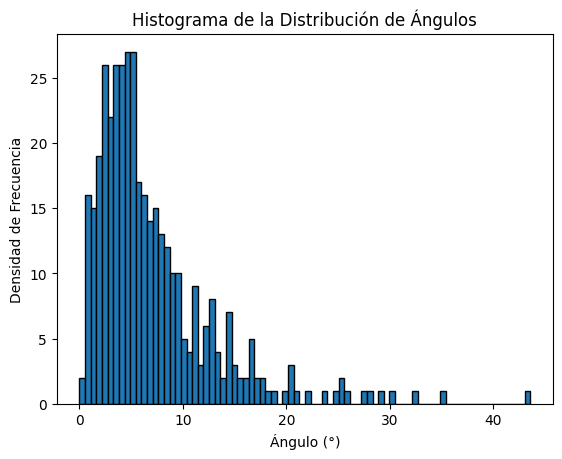

In [80]:
treshold = 12

# Filtrar la lista, manteniendo solo los valores mayores o iguales al umbral
nueva_lista = [x for x in list_angle if x <= 70]
plt.hist(
    nueva_lista,
    bins=80,
    edgecolor="black",
)

# Etiquetas y título
plt.xlabel("Ángulo (°)")
plt.ylabel("Densidad de Frecuencia")
plt.title("Histograma de la Distribución de Ángulos")

# Mostrar el gráfico
plt.show()

In [85]:
print(np.sqrt(np.array(nueva_lista) /len(nueva_lista)))

[0.12198372 0.14458028 0.18386792 0.14844882 0.09142367 0.12233304
 0.09875564 0.12966756 0.13533246 0.21573975 0.15001073 0.17725076
 0.08104706 0.13220461 0.11989837 0.11031209 0.10903163 0.09302386
 0.12602566 0.19377992 0.10574005 0.16737617 0.06404397 0.13509074
 0.06951923 0.20472987 0.1108366  0.09546688 0.07608118 0.16740067
 0.07786979 0.16115229 0.0788049  0.08201295 0.08061319 0.11326271
 0.03765873 0.04177029 0.08651437 0.09281715 0.05288824 0.1129159
 0.15441698 0.18514698 0.10999778 0.16190019 0.08857362 0.1410594
 0.16841183 0.04725379 0.22845671 0.13131399 0.14379985 0.29672028
 0.28672251 0.05590574 0.14593797 0.11314618 0.13398152 0.12497375
 0.06453923 0.10443532 0.09424424 0.07046972 0.1398488  0.05827671
 0.06667348 0.11812054 0.13097856 0.09760302 0.12861    0.09348492
 0.263731   0.09060649 0.09392728 0.10701094 0.1448395  0.08753855
 0.10119845 0.09315706 0.07972013 0.19355721 0.19742662 0.15613111
 0.07622879 0.15824452 0.10251764 0.1029212  0.07513305 0.066061